In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, Y = mnist['data'], mnist['target']

In [2]:
X.shape, Y.shape

((70000, 784), (70000,))

In [3]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
basic_knn = KNeighborsClassifier()
basic_knn.fit(X_train, Y_train)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
basic_predictions = basic_knn.predict(X_test)
basic_f1 = f1_score(Y_test, basic_predictions, average='macro')
basic_f1 #0.9687143421292884

(60000, 784) (60000,) (10000, 784) (10000,)


0.9687143421292884

In [5]:
import numpy as np
from scipy.ndimage.interpolation import shift

def add_shifts(X, Y, width, height, distance = 1):
    side = (2 * distance) + 1
    area = side ** 2
    expanded_X = np.repeat(X, area, axis=0)
    expanded_Y = np.repeat(Y, area)
    for index in range(len(X)):
        vertical =  ((index % area) // side) - 1
        horizontal = (index % side) - 1
        image = expanded_X[index]
        shifted_image = shift(image.reshape(height, width), [vertical, horizontal], cval=0, order=0, prefilter=False).reshape(height * width)
        expanded_X[index] = shifted_image
    return expanded_X, expanded_Y

In [6]:
X_train_expanded, Y_train_expanded = add_shifts(X_train, Y_train, 28, 28)
expanded_knn = KNeighborsClassifier()
expanded_knn.fit(X_train_expanded, Y_train_expanded)
expanded_predictions = expanded_knn.predict(X_test)
expanded_f1 = f1_score(Y_test, expanded_predictions, average='macro')
expanded_f1 #0.9683110112195875

0.9683110112195875

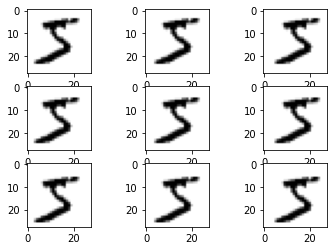

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3)
for index in range(9):
    digit = X_train_expanded[index]
    digit_image = digit.reshape(28, 28)
    axs[index // 3, index % 3].imshow(digit_image, cmap='binary')
plt.show()

In [8]:
X_train.sum() / 60000

26121.642416666666

In [9]:
X_train_expanded.sum() / 540000

26121.44501666667

In [10]:
for index in range(len(X_train)):
    digit = X_train[index]
    for offset in range(9):
        shifted_digit = X_train_expanded[(index * 9) + offset]
        if digit.sum() > shifted_digit.sum():
            print(index, (index * 9) + offset, digit.sum(), shifted_digit.sum())

71 645 20406.0 19981.0
71 646 20406.0 19981.0
71 647 20406.0 19981.0
91 825 25936.0 25538.0
91 826 25936.0 25538.0
91 827 25936.0 25538.0
123 1113 24399.0 23838.0
123 1114 24399.0 23838.0
123 1115 24399.0 23838.0
196 1770 27779.0 27389.0
196 1771 27779.0 27389.0
196 1772 27779.0 27389.0
282 2544 16471.0 16124.0
282 2545 16471.0 16124.0
282 2546 16471.0 16124.0
422 3804 15031.0 14546.0
422 3805 15031.0 14546.0
422 3806 15031.0 14546.0
426 3840 36729.0 36718.0
426 3841 36729.0 36718.0
426 3842 36729.0 36718.0
615 5537 25838.0 25470.0
615 5540 25838.0 25470.0
615 5543 25838.0 25470.0
627 5645 21014.0 20839.0
627 5648 21014.0 20839.0
627 5651 21014.0 20839.0
632 5694 26634.0 25927.0
632 5695 26634.0 25927.0
632 5696 26634.0 25927.0
640 5766 25065.0 24440.0
640 5767 25065.0 24440.0
640 5768 25065.0 24440.0
908 8178 22402.0 21817.0
908 8179 22402.0 21817.0
908 8180 22402.0 21817.0
942 8484 37365.0 36615.0
942 8485 37365.0 36615.0
942 8486 37365.0 36615.0
962 8664 19010.0 18476.0
962 8665 190

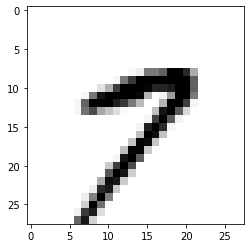

In [11]:
digit_image = X_train[71].reshape((28, 28))
plt.imshow(digit_image, cmap='binary')
plt.show()

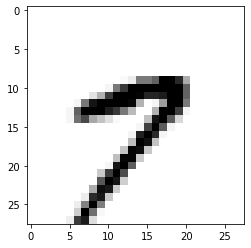

In [12]:
digit_image = X_train_expanded[645].reshape((28, 28))
plt.imshow(digit_image, cmap='binary')
plt.show()

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImageBorderer(BaseEstimator, TransformerMixin):
    def __init__(self, orig_height, orig_width, distance):
        self.orig_height = orig_height
        self.orig_width = orig_width
        self.distance = distance
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        new_width = (2 * distance) + orig_width
        new_height = (2 * distance) + orig_height
        new_area = new_width * new_height
        larger_images = np.zeros((len(X), new_area))
        for index in range(len(X)):
            digit = X[index]
            digit_image = digit.reshape(orig_height, orig_width)
            larger_image = np.append(np.zeros((height, distance)), digit_image, axis=1)
            larger_image = np.append(larger_image, np.zeros((height, distance)), axis=1)
            
            new_width = (2 * distance) + width
            larger_image = np.append(np.zeros((distance, new_width)), larger_image, axis=0)
            larger_image = np.append(larger_image, np.zeros((distance, new_width)),axis=0)
            
            larger_digit = larger_image.reshape(new_area)
            larger_images[index] = larger_digit
        return larger_images

In [16]:
def border_images(X):
    larger_images = np.zeros((len(X), 900))
    for index in range(len(X)):
        digit = X[index]
        digit_image = digit.reshape(28,28)
        larger_image = np.append(np.zeros((28,1)), digit_image, axis=1)
        larger_image = np.append(larger_image, np.zeros((28,1)), axis=1)
        larger_image = np.append(np.zeros((1,30)), larger_image, axis=0)
        larger_image = np.append(larger_image, np.zeros((1,30)),axis=0)
        larger_digit = larger_image.reshape(900)
        larger_images[index] = larger_digit
    return larger_images                           

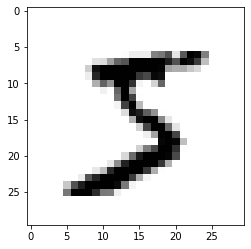

In [17]:
X_train_bordered = border_images(X_train)
X_test_bordered = border_images(X_test)
digit_image = X_train_bordered[0].reshape((30,30))
plt.imshow(digit_image, cmap='binary')
plt.show()

In [18]:
X_train_transformed, Y_train_transformed = add_shifts(X_train_bordered, Y_train, width=30, height=30)
X_train_transformed.sum() / 540000

26121.642416666666

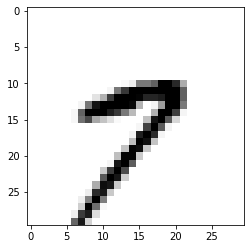

In [19]:
digit_image = X_train_transformed[645].reshape((30,30))
plt.imshow(digit_image, cmap='binary')
plt.show()

In [20]:
transformed_knn = KNeighborsClassifier()
transformed_knn.fit(X_train_transformed, Y_train_transformed)
transformed_predictions = transformed_knn.predict(X_test_bordered)
transformed_f1 = f1_score(Y_test, transformed_predictions, average='macro')
transformed_f1 #0.9683110112195875

0.9683110112195875

In [21]:
count = 0
for t, e in zip(transformed_predictions, expanded_predictions):
    if t != e:
        count = count + 1
count

0

In [22]:
X_train_transformed.sum()

14105686905.0

In [23]:
X_train_expanded.sum()

14105580309.0

In [24]:
X_train_transformed.shape

(540000, 900)

In [25]:
X_train_expanded.shape

(540000, 784)